## Предсказание стоимости жилья

В проекте вам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2.

импортируем библиотеки

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os

from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
import pandas as pd 
import numpy as np
import seaborn as sns

import pyspark

from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.mllib.stat import Statistics
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

In [2]:
pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator

запускаем spark сессию

In [3]:
spark = SparkSession \
    .builder \
    .master("local")\
    .appName("spk") \
    .getOrCreate()

# Подготовка данных

читаем данные и смотрим их типы

In [4]:
df = (spark.read
      .csv('/datasets/housing.csv',
           inferSchema=True,header= True))
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



разделяем на 10 частей и кешируем 

In [5]:
df = df.repartition(10).cache()

смотрим пропуски

In [6]:
Dict_Null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
Dict_Null

{'longitude': 0,
 'latitude': 0,
 'housing_median_age': 0,
 'total_rooms': 0,
 'total_bedrooms': 207,
 'population': 0,
 'households': 0,
 'median_income': 0,
 'median_house_value': 0,
 'ocean_proximity': 0}

смотрим корреляции

23/06/10 19:11:04 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/06/10 19:11:04 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+
|           longitude|            latitude|  housing_median_age|         total_rooms|total_bedrooms|          population|          households|       median_income|  median_house_value|
+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+
|                 1.0| -0.9246644339150412|-0.10819681311244828| 0.04456797771665521|           NaN| 0.09977322287464552| 0.05531009278239548|-0.01517586541417...|-0.04596661511797851|
| -0.9246644339150412|                 1.0|0.011172673530605373|-0.03609959585612...|           NaN|-0.10878474737766748|-0.07103543319190729|-0.07980912745971874| -0.1441602768746591|
|-0.10819681311244828|0.011172673530605373|                 1.0|-0.36126220

<AxesSubplot:>

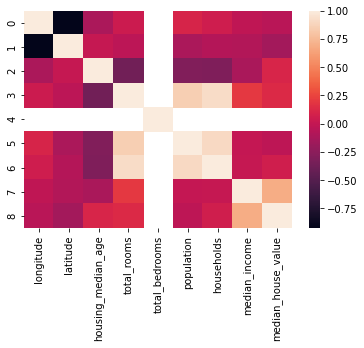

In [7]:
subset = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population','households',
         'median_income','median_house_value']

assembler = VectorAssembler(inputCols=subset, 
outputCol="features",handleInvalid='keep')
data = assembler.transform(df).select("features")

correlation = Correlation.corr(data,"features","pearson").collect()[0][0]

corrmatrix = correlation.toArray().tolist()
sup_df = spark.createDataFrame(corrmatrix,subset)
sup_df.show()
sns.heatmap(sup_df.toPandas())

заполняем пропуски

In [8]:
df=df.na.fill(int(df.approxQuantile('total_bedrooms', [0.5], 0)[0]))

In [9]:
Dict_Null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
Dict_Null

{'longitude': 0,
 'latitude': 0,
 'housing_median_age': 0,
 'total_rooms': 0,
 'total_bedrooms': 0,
 'population': 0,
 'households': 0,
 'median_income': 0,
 'median_house_value': 0,
 'ocean_proximity': 0}

In [10]:
df.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|   -116.3|   33.68|              10.0|     2387.0|         481.0|     863.0|     304.0|       2.8882|          137500.0|         INLAND|
|   -120.1|   39.33|               9.0|     2738.0|         510.0|    1193.0|     412.0|       4.3958|          124800.0|         INLAND|
|  -118.15|   33.85|              36.0|     1491.0|         259.0|     699.0|     266.0|       4.0781|          217300.0|      <1H OCEAN|
|  -120.79|   37.49|              44.0|     1186.0|         225.0|     687.0|     234.0|       3.4167|          160700.0|         INLAND|
|  -118.38|   33.87|              

делим на тренировочную и тестовую выборки

In [11]:
(train_data, test_data) = df.randomSplit([.7,.3], seed=3826)
print(train_data.count(), test_data.count()) 

14452 6188


создаем котегориальне, численные и таргет переменные

In [12]:
numerical_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population','households',
         'median_income']
categorical_cols= ['ocean_proximity']
target = "median_house_value" 

задаем индекс категориальным переменным

In [13]:
indexer = StringIndexer(inputCols=categorical_cols, 
                        outputCols=[c+'_idx' for c in categorical_cols],handleInvalid="skip") 
strInd= indexer.fit(train_data)
train_data=strInd.transform(train_data)
test_data = strInd.transform(test_data)

cols = [c for c in train_data.columns for i in categorical_cols if (c.startswith(i))]
train_data.select(cols).show(3) 
test_data.select(cols).show(3)

+---------------+-------------------+
|ocean_proximity|ocean_proximity_idx|
+---------------+-------------------+
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
+---------------+-------------------+
only showing top 3 rows

+---------------+-------------------+
|ocean_proximity|ocean_proximity_idx|
+---------------+-------------------+
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
+---------------+-------------------+
only showing top 3 rows



техникой ohe преобразуем категориальные переменные

In [14]:
encoder = OneHotEncoder(inputCols=[c+'_idx' for c in categorical_cols],
                        outputCols=[c+'_ohe' for c in categorical_cols])
ohe=encoder.fit(train_data)
train_data = ohe.transform(train_data)
test_data= ohe.transform(test_data)

cols = [c for c in train_data.columns for i in categorical_cols if (c.startswith(i))]
train_data.select(cols).show(3)
test_data.select(cols).show(3)

+---------------+-------------------+-------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|
+---------------+-------------------+-------------------+
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
+---------------+-------------------+-------------------+
only showing top 3 rows

+---------------+-------------------+-------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|
+---------------+-------------------+-------------------+
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
+---------------+-------------------+-------------------+
only showing top 3 rows



преобразуем в векторы

In [15]:
categorical_assembler =VectorAssembler(inputCols=[c+'_ohe' for c in categorical_cols],
                                        outputCol="categorical_features")
train_data = categorical_assembler.transform(train_data) 
test_data = categorical_assembler.transform(test_data)

In [16]:
numerical_assembler = VectorAssembler(inputCols=numerical_cols,outputCol="numerical_features")
train_data = numerical_assembler.transform(train_data) 
test_data = numerical_assembler.transform(test_data)

преобразуем численные переменные техникой standardScaler

In [17]:
standardScaler = StandardScaler(inputCol='numerical_features',
                                                                outputCol="numerical_features_scaled")
stSc = standardScaler.fit(train_data)
train_data=stSc.transform(train_data)
test_data=stSc.transform(test_data)

сохраням все в переменные

In [18]:
all_features = ['categorical_features','numerical_features_scaled']

final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol="features") 
train_data = final_assembler.transform(train_data)
test_data = final_assembler.transform(test_data)

train_data.select(all_features).show(3) 
test_data.select(all_features).show(3)

+--------------------+-------------------------+
|categorical_features|numerical_features_scaled|
+--------------------+-------------------------+
|       (4,[2],[1.0])|     [-62.157226929199...|
|       (4,[2],[1.0])|     [-62.147215295643...|
|       (4,[2],[1.0])|     [-62.117180394977...|
+--------------------+-------------------------+
only showing top 3 rows

+--------------------+-------------------------+
|categorical_features|numerical_features_scaled|
+--------------------+-------------------------+
|       (4,[2],[1.0])|     [-62.177250196310...|
|       (4,[2],[1.0])|     [-62.167238562754...|
|       (4,[2],[1.0])|     [-62.157226929199...|
+--------------------+-------------------------+
only showing top 3 rows



# Обучение моделей

создаем модель и подбираем гиперпараметры

In [19]:
lr = LinearRegression(labelCol=target,regParam=0.5,elasticNetParam=1,aggregationDepth=10,featuresCol ='features')

In [20]:
lr_ncl= LinearRegression(labelCol=target,regParam=0.5,elasticNetParam=1,aggregationDepth=10,featuresCol ='numerical_features_scaled')

обучаем модели

In [21]:
model = lr.fit(train_data)

In [22]:
model_ncl = lr_ncl.fit(train_data) 

In [23]:
predictions = model.transform(test_data)

predictedLabes = predictions.select("median_house_value", "prediction")
predictedLabes.show() 

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|           66900.0|119386.80873314757|
|           90100.0|198222.32275805017|
|           68300.0| 145564.4968442223|
|           94800.0|222040.70741731673|
|           92100.0|189579.01146639464|
|           92600.0| 153030.6342120599|
|          151400.0|193514.63561075972|
|           95300.0|176520.06441829447|
|          100000.0| 155737.3986051767|
|           77200.0|143071.98162558582|
|          105400.0|157127.90234092483|
|           95800.0|178690.83153026737|
|           37500.0| 46836.64163172897|
|          240900.0|216180.08030076744|
|          266700.0| 281518.1231062114|
|          134200.0|180790.49676398886|
|          269800.0| 255646.5931341052|
|           73500.0|25505.504173244815|
|          270700.0|254289.28628338082|
|          156500.0|214291.06994196493|
+------------------+------------------+
only showing top 20 rows



In [24]:
predictions_ncl = model_ncl.transform(test_data)

predictedLabes_ncl = predictions_ncl.select("median_house_value", "prediction")
predictedLabes_ncl.show()

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|           66900.0| 67094.33224156033|
|           90100.0| 164434.4621307766|
|           68300.0|110703.98011779878|
|           94800.0| 200006.5956101399|
|           92100.0| 157853.3880141871|
|           92600.0|122566.91564230667|
|          151400.0|181082.47960770782|
|           95300.0|166618.56353698252|
|          100000.0| 135443.5224694633|
|           77200.0|122188.29400525009|
|          105400.0|137752.60984208854|
|           95800.0|163821.92033216543|
|           37500.0| 44677.75587410759|
|          240900.0|206328.47630794626|
|          266700.0| 272529.3215388423|
|          134200.0|  161356.842925441|
|          269800.0|247213.51053347113|
|           73500.0| 36918.22086199187|
|          270700.0| 247481.0169582311|
|          156500.0|201593.28316568304|
+------------------+------------------+
only showing top 20 rows



# Анализ результатов

In [27]:
predictions_collect = predictedLabes.collect()
predictions_list = [ (float(i[0]), float(i[1])) for i in predictions_collect]
scoreAndLabels = spark.sparkContext.parallelize(predictions_list)
metrics = RegressionMetrics(scoreAndLabels)

In [28]:
predictions_ncl_collect = predictedLabes_ncl.collect()
predictions_ncl_list = [ (float(i[0]), float(i[1])) for i in predictions_ncl_collect]
scoreAndLabels_ncl = spark.sparkContext.parallelize(predictions_ncl_list)
metrics_ncl = RegressionMetrics(scoreAndLabels_ncl)

In [29]:
print(metrics.r2)
print(metrics.meanAbsoluteError)
print(metrics.rootMeanSquaredError)

0.45433365895750677
50126.366255404944
67924.52562119954


In [30]:
print(metrics_ncl.r2)
print(metrics_ncl.meanAbsoluteError)
print(metrics_ncl.rootMeanSquaredError)

0.4335871888333084
51059.11339990333
68599.46770678369


In [31]:
spark.stop()

# вывод

в ходе работы были выполнены следующие этапы:
    - запущена spark сессия
    - прочитаны и просмотренны данные
    - посмотрены пропуски и корреляции
    - заполнены пропуски
    - данные разбиты на тестовую и тренировочные выборки
    - преобразованы категриальные и численные переменные
    - обучены две модели линейной регресии:
        первая модель обучена на 'полных' данных
        вторая модель обучена только на численных данных
    - сделаны предсказания моделей
    - посмотренны метрики r2, mae,rmse.
    у модели обученной на полных данных полуились следующие значения метрик:
    r2 = 0.45
    MAE = 50126.36
    RMSE = 67924.52
    
    у модели обученной только на численных данных метрики такие:
    r2 = 0.43
    MAE = 51059.11
    RMSE = 68599.46
    - исходя из полученных метрик мы можем сделать вывод, что модель обученная на 